# 01: Introduction to xsnow and Loading Data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Austfi/xsnowForPatrol/blob/main/notebooks/01_introduction_and_loading_data.ipynb)

This notebook introduces you to xsnow and how to load snowpack data.

## What You'll Learn

- What xsnow is and why it's useful
- Understanding xsnow's 5-dimensional data model
- How to load sample data
- Exploring dataset structure and metadata
- Creating your first visualization

> **Note**: If you're new to Python, NumPy, pandas, or xarray, check out the optional reference notebook `00_python_fundamentals_reference.ipynb` for a quick introduction to these libraries.


## Installation (For Colab Users)

If you're using Google Colab, run the cell below to install xsnow and dependencies. If you're running locally and have already installed xsnow, you can skip this cell.

In [1]:

%pip install -q numpy pandas xarray matplotlib seaborn dask netcdf4
%pip install -q git+https://gitlab.com/avacollabra/postprocessing/xsnow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.5/377.5 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.3/263.3 kB 19.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have

## Part 1: What is xsnow?

**xsnow** is a Python library designed to make working with snowpack simulation data efficient and intuitive. It's built specifically for data from the SNOWPACK model (and other snow models), which outputs detailed information about snow layers over time.

### Why xsnow?

- **Handles complex file formats**: SNOWPACK outputs come in specialized formats (.pro, .smet) that xsnow can parse automatically
- **Organized data structure**: Instead of juggling hundreds of separate files, xsnow organizes everything into a single, coherent dataset
- **Powerful analysis tools**: Built-in functions for common snowpack analyses (SWE, weak layers, stability indices)
- **Built on proven libraries**: Uses xarray, NumPy, and pandas under the hood, so you get their full power

### The Big Picture

Think of xsnow as a translator: it takes raw SNOWPACK output files and converts them into a format that's easy to work with in Python. Instead of manually parsing text files, you get a clean, organized dataset where you can ask questions like "Show me all weak layers on north-facing slopes after February 1st" with simple code.

**Why do we need xsnow?**

With xsnow, you get:
- Automatic file parsing with `xsnow.read()`
- Unified data structure (xsnowDataset) for all your data
- Label-based indexing: `ds.sel(location="VIR1A", time="2024-02-01")`
- Built-in analysis functions: `ds.compute_swe()`, `ds.find_weak_layers()`
- Automatic alignment and broadcasting when combining datasets
- Rich metadata preserved from original files
- Access to full xarray ecosystem for advanced operations


## Part 2: Understanding xsnow's Data Model

xsnow organizes snowpack data using **5 key dimensions**. This might sound complex, but it's actually very logical once you understand it.


### The 5 Dimensions

1. **location**: The site or grid point (e.g., "VIR1A", "Station_1")
2. **time**: When the profile was measured/simulated
3. **slope**: Different slope aspects at the same location (north-facing, south-facing, etc.)
4. **realization**: Different model runs or scenarios (for ensemble runs)
5. **layer**: The vertical layers within the snowpack (layer 0 = surface, higher numbers = deeper)

### Why This Structure?

This structure allows you to ask powerful questions:
- "Show me density profiles for all locations on February 1st"
- "Compare north vs south-facing slopes"
- "Find weak layers across all time steps"
- All without writing loops of code

### Profile-level vs Layer-level Variables

- **Profile-level**: Properties of the entire snowpack (e.g., total snow height HS). These don't vary by layer.
- **Layer-level**: Properties of individual layers (e.g., density, temperature). These vary by layer.

Let's see this in action once we load some data!


## Part 3: Loading Data with xsnow

Now let's actually load some data! xsnow can read SNOWPACK output files in `.pro` (profile) and `.smet` (meteorological) formats.

### Understanding File Formats

- **`.pro` files**: Contain time series of snow profiles with layer-by-layer data
- **`.smet` files**: Contain time series of scalar variables (temperature, precipitation, etc.) without layers

### Using xsnow Sample Data

xsnow includes built-in sample data that we can use for learning! This makes it easy to get started without needing to download or generate your own files. We'll use `xsnow.single_profile_timeseries()` to load the sample data.


In [2]:
import xsnow
import matplotlib.pyplot as plt

# Load sample data
ds = xsnow.single_profile_timeseries()
ds


<xsnowDataset>
  Locations:  1
  Timestamps: 381 (2024-01-17--2024-02-02)
  Profiles:   NotImplementedYet

    employing the <xarray.Dataset> Size: 3MB
    Dimensions:                   (location: 1, time: 381, slope: 1,
                                   realization: 1, layer: 59)
    Coordinates:
      * location                  (location) <U29 116B 'Kasererwinkl_C6'
      * time                      (time) datetime64[ns] 3kB 2024-01-17T16:00:00 ....
      * slope                     (slope) int64 8B 0
      * realization               (realization) int64 8B 0
      * layer                     (layer) int64 472B 0 1 2 3 4 5 ... 54 55 56 57 58
        latitude                  (location) float64 8B 47.1
        longitude                 (location) float64 8B 11.62
        altitude                  (location) float64 8B 1.681e+03
        inclination               (location, slope) int64 8B 16
        azimuth                   (location, slope) int64 8B 270
        z                         (location, time, slope, realization, layer) float32 90kB ...
    Data variables: (12/90)
        air_content               (location, time, slope, realization, layer) float32 90kB ...
        bond_size                 (location, time, slope, realization, layer) float32 90kB ...
        coord_number              (location, time, slope, realization, layer) float32 90kB ...
        dendricity                (location, time, slope, realization, layer) float32 90kB ...
        density                   (location, time, slope, realization, layer) float32 90kB ...
        element_ID                (location, time, slope, realization, layer) float32 90kB ...
        ...                        ...
        Ss                        (location, slope, realization, time) float64 3kB ...
        zS4                       (location, slope, realization, time) float64 3kB ...
        S4                        (location, slope, realization, time) float64 3kB ...
        zS5                       (location, slope, realization, time) float64 3kB ...
        S5                        (location, slope, realization, time) float64 3kB ...
        HS                        (location, time, slope, realization) float32 2kB ...
    Attributes:
        Conventions:  CF-1.8
        title:        Snowpack Profile for Kasererwinkl_C6
        source:       SNOWPACK model output (.pro file)
        history:      2025-11-13T16:31:57.272791+00:00: Created by xsnow.
        crs:          EPSG:4326

## Plot a Snow Profile!

Let's create a visual plot right away to show what xsnow can do.

Even though we haven't covered visualization in detail yet, let's plot a snow profile to see data pulled out and visualized from xsnow.


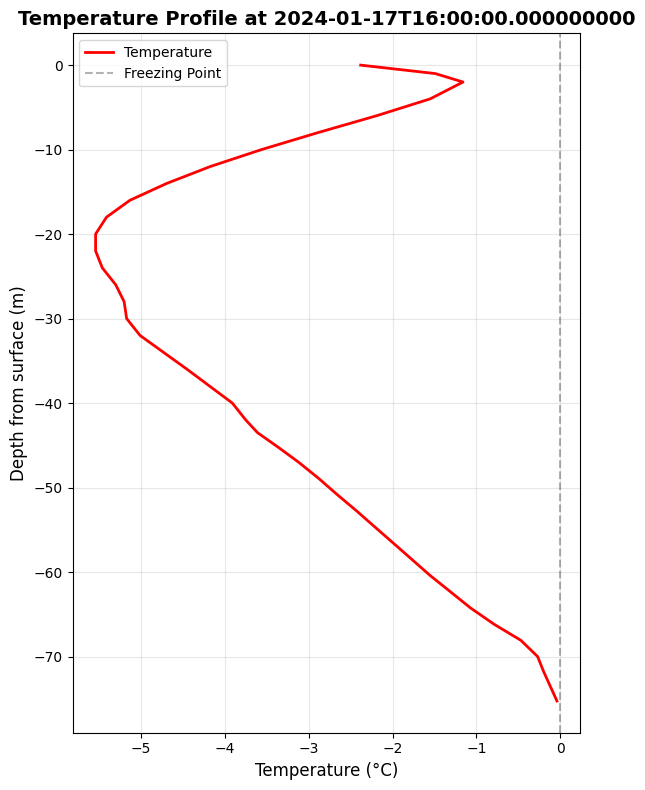

Congratulations! You just pulled a profile out of a dataset and plotted it


In [3]:
# Select a single profile (first location, first time, flat slope, first realization)
# ds.isel is used to select a single profile from the dataset based on the coordinates given
profile = ds.isel(location=0, time=0, slope=0, realization=0)

# Get depth and temperature
# profile.coords['z'].values is used to get the depth ('z' is the coordinate name)
# profile['temperature'].values is used to get the temperature data
depth = profile.coords['z'].values  # z stores below surface depth from 0 as negative values
temp = profile['temperature'].values
time = profile.coords['time'].values

# Create a simple plot
fig, ax = plt.subplots(figsize=(6, 8))
ax.plot(temp, depth, 'r-', linewidth=2, label='Temperature')
ax.axvline(x=0, color='k', linestyle='--', alpha=0.3, label='Freezing Point')
ax.set_xlabel('Temperature (°C)', fontsize=12)
ax.set_ylabel('Depth from surface (m)', fontsize=12)
ax.set_title(f'Temperature Profile at {time}', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

print("Congratulations! You just pulled a profile out of a dataset and plotted it")



### Understanding the Dataset Structure

**Two Bites Pattern**: Let's understand datasets in two ways:

1. **Conceptually (First Bite)**: An xsnowDataset is like a smart container that organizes all your snowpack data. It knows about locations, times, layers, and keeps everything connected. Think of it as a multi-dimensional spreadsheet where each "sheet" is a different variable (density, temperature, etc.), and the rows/columns are organized by location, time, and depth.

2. **Technically (Second Bite)**: When you load data with `xsnow.read()`, you get an **xsnowDataset**. This is a special wrapper around an xarray Dataset that's designed for snowpack data. It extends xarray's functionality with snowpack-specific methods and metadata.

### What's in an xsnowDataset?

An xsnowDataset contains several key components:

1. **Dimensions**: The axes of your data (location, time, slope, realization, layer)
   - Define the shape and size of your data
   - Example: `location: 3, time: 100, layer: 20` means 3 locations, 100 time steps, up to 20 layers

2. **Coordinates**: Labels for each dimension
   - Provide meaningful names/values for each position along a dimension
   - Example: location names like "VIR1A", time values like "2024-01-15", layer indices 0-19

3. **Data Variables**: The actual data arrays
   - Each variable (density, temperature, etc.) is stored as a DataArray
   - Can be profile-level (no layer dimension) or layer-level (has layer dimension)
   - Example: `density` has dimensions `(location, time, slope, realization, layer)`

4. **Attributes**: Metadata about variables and the dataset
   - Units, descriptions, source information
   - Example: `density.attrs['units'] = 'kg/m³'`

**Key Relationship**: `xsnowDataset` is a wrapper around `xarray.Dataset`. This means:
- You can use most xarray methods directly: `ds.mean()`, `ds.sel()`, `ds.groupby()`, etc.
- xsnow adds snowpack-specific methods and metadata
- You can access the underlying xarray Dataset if needed (though usually not necessary)

Let's explore what's inside:


In [5]:
datapath = xsnow.sample_data.snp_gridded_dir()
print(datapath)

/root/.cache/xsnow-snp-gridded


This function downloaded and creates a directory path for smets and pro files from a sample dataset. Below reads in a single pro file. We can view this with print(ds) in cell output text or just ds to see the information about the file in a HTML table.

In [10]:
ds = xsnow.read(f"{datapath}/pros/gridded/VIR1A.pro")
print(ds)

<xsnowDataset>
  Locations:  1
  Timestamps: 373 (2024-01-18--2024-02-02)
  Profiles:   NotImplementedYet

    employing the <xarray.Dataset> Size: 488kB
    Dimensions:                   (location: 1, time: 373, slope: 1,
                                   realization: 1, layer: 12)
    Coordinates:
      * location                  (location) <U5 20B 'VIR1A'
      * time                      (time) datetime64[ns] 3kB 2024-01-18 ... 2024-0...
      * slope                     (slope) int64 8B 0
      * realization               (realization) int64 8B 0
      * layer                     (layer) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
        latitude                  (location) float64 8B 47.15
        longitude                 (location) float64 8B 11.19
        altitude                  (location) float64 8B 2.372e+03
        inclination               (location, slope) int64 8B 0
        azimuth                   (location, slope) int64 8B 0
        z                         (location, t

In [11]:
ds

<xsnowDataset>
  Locations:  1
  Timestamps: 373 (2024-01-18--2024-02-02)
  Profiles:   NotImplementedYet

    employing the <xarray.Dataset> Size: 488kB
    Dimensions:                   (location: 1, time: 373, slope: 1,
                                   realization: 1, layer: 12)
    Coordinates:
      * location                  (location) <U5 20B 'VIR1A'
      * time                      (time) datetime64[ns] 3kB 2024-01-18 ... 2024-0...
      * slope                     (slope) int64 8B 0
      * realization               (realization) int64 8B 0
      * layer                     (layer) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
        latitude                  (location) float64 8B 47.15
        longitude                 (location) float64 8B 11.19
        altitude                  (location) float64 8B 2.372e+03
        inclination               (location, slope) int64 8B 0
        azimuth                   (location, slope) int64 8B 0
        z                         (location, time, slope, realization, layer) float32 18kB ...
    Data variables: (12/27)
        air_content               (location, time, slope, realization, layer) float32 18kB ...
        bond_size                 (location, time, slope, realization, layer) float32 18kB ...
        coord_number              (location, time, slope, realization, layer) float32 18kB ...
        dendricity                (location, time, slope, realization, layer) float32 18kB ...
        density                   (location, time, slope, realization, layer) float32 18kB ...
        element_ID                (location, time, slope, realization, layer) float32 18kB ...
        ...                        ...
        stress                    (location, time, slope, realization, layer) float32 18kB ...
        temperature               (location, time, slope, realization, layer) float32 18kB ...
        temperature_gradient      (location, time, slope, realization, layer) float32 18kB ...
        viscosity                 (location, time, slope, realization, layer) float32 18kB ...
        viscous_deformation_rate  (location, time, slope, realization, layer) float32 18kB ...
        HS                        (location, time, slope, realization) float32 1kB ...
    Attributes:
        Conventions:  CF-1.8
        title:        Snowpack Profile for VIR1A
        source:       SNOWPACK model output (.pro file)
        history:      2025-11-13T16:45:24.155968+00:00: Created by xsnow.
        crs:          EPSG:4326

You can inspect the dataset with standard xarray accessors such as:



*   ds.sizes # Lists dimensions and sizes
*   ds.coords # Lists coordinates and their info
*   ds.data_vars # Lists all data variables
*   ds.attrs # Lists all dataset variables



In [14]:
ds.sizes



Frozen({'location': 1, 'time': 373, 'slope': 1, 'realization': 1, 'layer': 12})

In [15]:
ds.coords

Coordinates:
  * location     (location) <U5 20B 'VIR1A'
  * time         (time) datetime64[ns] 3kB 2024-01-18 ... 2024-02-02T12:00:00
  * slope        (slope) int64 8B 0
  * realization  (realization) int64 8B 0
  * layer        (layer) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
    latitude     (location) float64 8B 47.15
    longitude    (location) float64 8B 11.19
    altitude     (location) float64 8B 2.372e+03
    inclination  (location, slope) int64 8B 0
    azimuth      (location, slope) int64 8B 0
    z            (location, time, slope, realization, layer) float32 18kB 0.0...

In [16]:
ds.data_vars

Data variables:
    air_content               (location, time, slope, realization, layer) float32 18kB ...
    bond_size                 (location, time, slope, realization, layer) float32 18kB ...
    coord_number              (location, time, slope, realization, layer) float32 18kB ...
    dendricity                (location, time, slope, realization, layer) float32 18kB ...
    density                   (location, time, slope, realization, layer) float32 18kB ...
    element_ID                (location, time, slope, realization, layer) float32 18kB ...
    grain_size                (location, time, slope, realization, layer) float32 18kB ...
    grain_type                (location, time, slope, realization, layer) float32 18kB ...
    gs_difference             (location, time, slope, realization, layer) float32 18kB ...
    hand_hardness             (location, time, slope, realization, layer) float32 18kB ...
    hardness_difference       (location, time, slope, realization, layer) 

In [17]:
ds.attrs

{'Conventions': 'CF-1.8',
 'title': 'Snowpack Profile for VIR1A',
 'source': 'SNOWPACK model output (.pro file)',
 'history': '2025-11-13T16:45:24.155968+00:00: Created by xsnow.',
 'crs': 'EPSG:4326'}

### Inspecting Specific Variables

Let's look at individual variables to understand the difference between profile-level and layer-level data:


In [18]:
# Inspect individual variable density from the dataset and print
density = ds['density']
print(density)


<xarray.DataArray 'density' (location: 1, time: 373, slope: 1, realization: 1,
                             layer: 12)> Size: 18kB
array([[[[[100.2,   nan,   nan, ...,   nan,   nan,   nan]]],


        [[[100.3,   nan,   nan, ...,   nan,   nan,   nan]]],


        [[[100.3,   nan,   nan, ...,   nan,   nan,   nan]]],


        ...,


        [[[213.9, 209. , 223.7, ..., 171.9, 142.4, 124.9]]],


        [[[214. , 209.2, 223.7, ..., 172.6, 143. , 125. ]]],


        [[[214.2, 209.3, 223.8, ..., 173.3, 143.6, 125. ]]]]],
      dtype=float32)
Coordinates:
  * location     (location) <U5 20B 'VIR1A'
  * time         (time) datetime64[ns] 3kB 2024-01-18 ... 2024-02-02T12:00:00
  * slope        (slope) int64 8B 0
  * realization  (realization) int64 8B 0
  * layer        (layer) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
    latitude     (location) float64 8B 47.15
    longitude    (location) float64 8B 11.19
    altitude     (location) float64 8B 2.372e+03
    inclination  (location, slope) int64 8

In [19]:
# Inspect the individual variable HS from the dataset and print
HS = ds['HS']
print(HS)

<xarray.DataArray 'HS' (location: 1, time: 373, slope: 1, realization: 1)> Size: 1kB
array([[[[ 2.2 ]],

        [[ 2.21]],

        [[ 2.21]],

        [[ 2.21]],

        [[ 2.21]],

        [[ 2.21]],

        [[ 2.2 ]],

        [[ 2.2 ]],

        [[ 2.2 ]],

        [[ 2.2 ]],

...

        [[17.94]],

        [[17.92]],

        [[17.9 ]],

        [[17.88]],

        [[17.87]],

        [[17.85]],

        [[17.84]],

        [[17.82]],

        [[17.8 ]],

        [[17.78]]]], dtype=float32)
Coordinates:
  * location     (location) <U5 20B 'VIR1A'
  * time         (time) datetime64[ns] 3kB 2024-01-18 ... 2024-02-02T12:00:00
  * slope        (slope) int64 8B 0
  * realization  (realization) int64 8B 0
    latitude     (location) float64 8B 47.15
    longitude    (location) float64 8B 11.19
    altitude     (location) float64 8B 2.372e+03
    inclination  (location, slope) int64 8B 0
    azimuth      (location, slope) int64 8B 0
Attributes:
    long_name:  Total Snow Height
    

In [23]:
# Inspect an individual variable in the unit and print the units used
hs_unit = ds['HS'].units
print(hs_unit)

density_unit = ds['density'].units
print(density_unit)

m
kg m-3


### Understanding Metadata

xsnow attaches useful metadata to variables (like units, descriptions). Let's check:


In [ ]:
# Check attributes (metadata) for a variable
print("Density variable attributes:")
for key, value in ds['density'].attrs.items():
    print(f"  {key}: {value}")

# Check dataset-level attributes
print("\nDataset-level attributes:")
for key, value in ds.attrs.items():
    print(f"  {key}: {value}")


### The Special 'z' Coordinate

xsnow automatically computes a depth coordinate `z` that represents depth below the snow surface:
- `z = 0` at the snow surface
- `z` is negative downward (so `z = -0.5` means 50 cm below surface)

This is very useful for analysis!


In [ ]:
# Loading multiple files (for reference - we'll cover this in detail in notebook 05)
# xsnow can load and merge multiple files at once:
# ds = xsnow.read(["data/station1.pro", "data/station2.pro"])  # List of files
# ds = xsnow.read("data/")  # Entire directory
